In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# 读取数据并筛选年龄
df = pd.read_csv('sph6004_assignment1_data.csv')

In [2]:
# # 打印所有的数值变量
# print("\nNumerical Variables:")
# print(df.select_dtypes(include=['number']).columns)

# 监测id有没有重复
print(df['id'].duplicated().sum())

# 监测id有没有缺失
print(df['id'].isnull().sum())

# drop掉id列
df = df.drop('id', axis=1)

df_filtered = df[(df['admission_age'] >= 18) & (df['admission_age'] <= 89)]

0
0


Number of columns with missing ratio < 0.2: 67
Number of columns with missing ratio >= 0.2: 97


<ipython-input-3-c044319f1d70>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_ratio.index, y=missing_ratio.values, palette=colors)  # 使用统一颜色


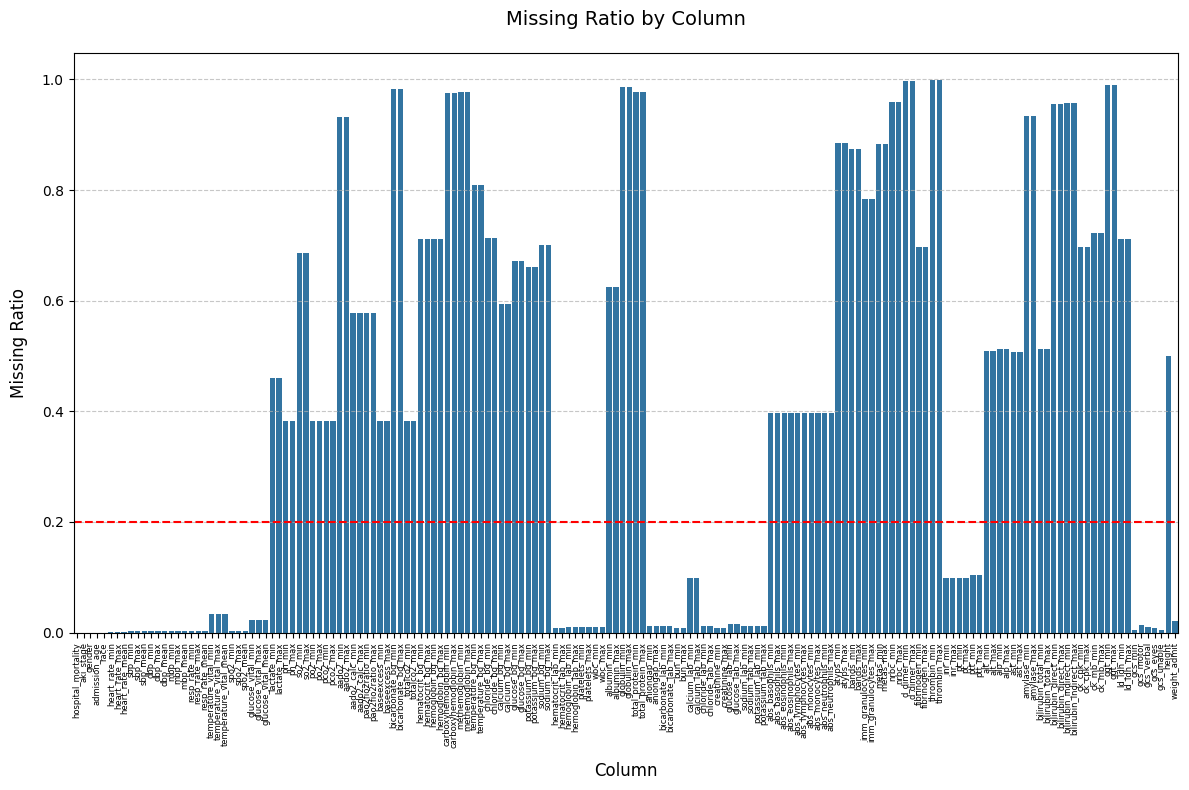

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算缺失率
missing_ratio = df_filtered.isnull().mean()

colors = ['#1f77b4' for _ in missing_ratio]

# 计算20%以下和以上的数量
num_below_20 = (missing_ratio < 0.2).sum()
num_above_20 = (missing_ratio >= 0.2).sum()
print(f"Number of columns with missing ratio < 0.2: {num_below_20}")
print(f"Number of columns with missing ratio >= 0.2: {num_above_20}")

# 可视化所有列的缺失值比例
plt.figure(figsize=(12, 8))  # 调整图表大小
sns.barplot(x=missing_ratio.index, y=missing_ratio.values, palette=colors)  # 使用统一颜色
plt.xticks(rotation=90, fontsize=6)  # 旋转列名并调整字体大小
plt.xlabel('Column', fontsize=12, labelpad=10)  # 增加X轴标签字体大小和间距
plt.ylabel('Missing Ratio', fontsize=12, labelpad=10)  # 增加Y轴标签字体大小和间距
plt.title('Missing Ratio by Column', fontsize=14, pad=20)  # 添加标题
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加水平网格线

# 在20%处画一条横向的红色虚线
plt.axhline(y=0.2, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()  # 自动调整布局以避免重叠

# 排除缺失率>20%的变量
df_filtered = df_filtered.loc[:, missing_ratio < 0.2]

plt.show()

In [4]:
# 检查aki_stage有没有缺失
print(df_filtered['aki_stage'].isnull().sum())

# 检查aki_stage是不是分类变量
print(df_filtered['aki_stage'].dtype)

# 转换成分类变量
df_filtered['aki_stage'] = df_filtered['aki_stage'].astype('category')

# 检查aki_stage是不是分类变量
print(df_filtered['aki_stage'].dtype)

# 打印所有的分类变量
print("Categorical Variables:")
print(df.select_dtypes(include=['object']).columns)

0
int64
category
Categorical Variables:
Index(['gender', 'race'], dtype='object')


In [5]:
# 检测异常值并转为缺失值
for col in df_filtered.select_dtypes(include=['number']).columns:
    mean = df_filtered[col].mean()
    std = df_filtered[col].std()
    df_filtered.loc[(df_filtered[col] < mean - 3*std) | (df_filtered[col] > mean + 3*std), col] = np.nan

# 插补缺失值
# 分类变量使用众数插补
cat_cols = df_filtered.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df_filtered[cat_cols] = imputer_cat.fit_transform(df_filtered[cat_cols])

# 数值变量使用KNN插补
num_cols = df_filtered.select_dtypes(include=['number']).columns
imputer_knn = KNNImputer(n_neighbors=5)
df_filtered[num_cols] = imputer_knn.fit_transform(df_filtered[num_cols])

# # 数值变量用中位数插补
# num_cols = df_filtered.select_dtypes(include=['number']).columns
# imputer_num = SimpleImputer(strategy='median')
# df_filtered[num_cols] = imputer_num.fit_transform(df_filtered[num_cols])

# 分离特征和目标变量
X = df_filtered.drop('aki_stage', axis=1)  # 特征变量
y = df_filtered['aki_stage']              # 目标变量（不标准化）

# 分类变量独热编码
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 分类变量独热编码
df_filtered = pd.get_dummies(df_filtered, columns=cat_cols, drop_first=True)

# 数据标准化
scaler = StandardScaler()
df_filtered[num_cols] = scaler.fit_transform(df_filtered[num_cols])

In [6]:
# 划分训练集和测试集
X = df_filtered.drop('aki_stage', axis=1)  # 假设目标变量为'aki_stage'
y = df_filtered['aki_stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 再次检查 y_train 的类型和值
print("y_train 数据类型:", y_train.dtype)
print("y_train 唯一值:", y_train.unique())

y_train 数据类型: category
y_train 唯一值: [2, 0, 1, 3]
Categories (4, int64): [0, 1, 2, 3]


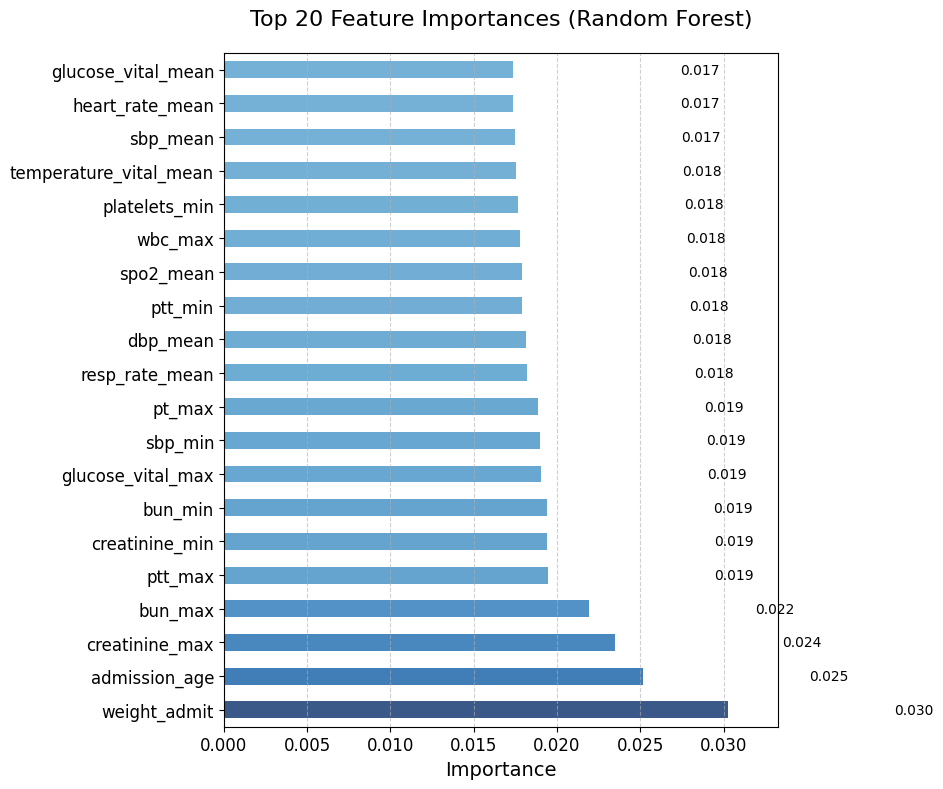

RF Selected Features:
Index(['weight_admit', 'admission_age', 'creatinine_max', 'bun_max', 'ptt_max',
       'creatinine_min', 'bun_min', 'glucose_vital_max', 'sbp_min', 'pt_max',
       'resp_rate_mean', 'dbp_mean', 'ptt_min', 'spo2_mean', 'wbc_max',
       'platelets_min', 'temperature_vital_mean', 'sbp_mean',
       'heart_rate_mean', 'glucose_vital_mean', 'platelets_max',
       'glucose_lab_max', 'sbp_max', 'mbp_mean'],
      dtype='object')


In [8]:
# 特征重要性分析（随机森林）
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 计算特征重要性
importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# 取前20个特征
top_20_importance = importance.head(20)

# 创建横向条形图
plt.figure(figsize=(10, 8))  # 调整图表大小
ax = top_20_importance.plot(kind='barh',
                            color=plt.cm.Blues(top_20_importance / top_20_importance.max()),  # 蓝色渐变色
                            alpha=0.8)  # 调整透明度

# 美化设置
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=16, pad=20)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('')  # 隐藏Y轴标签
plt.xlim(0, top_20_importance.max() * 1.1)  # 固定X轴范围，留出空白

# 调整坐标轴标签
plt.yticks(fontsize=12)  # 增大字段名字体
plt.xticks(fontsize=12)  # 增大X轴标签字体

# 添加网格线
ax.xaxis.grid(True, linestyle='--', alpha=0.6)

# 标注数值
for i, value in enumerate(top_20_importance):
    ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=10, color='black')  # 在条形右侧标注数值

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()

# 取前50个特征作为最终特征
RF_features = importance.index[:24]

print("RF Selected Features:")
print(RF_features)

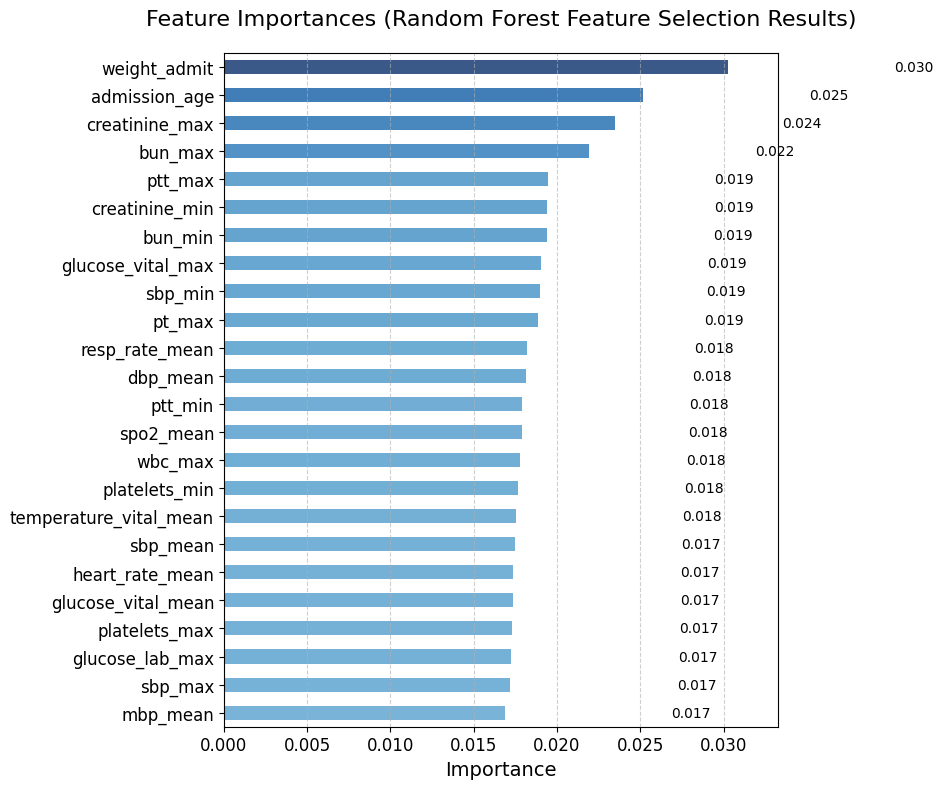

RF Selected Features:
Index(['weight_admit', 'admission_age', 'creatinine_max', 'bun_max', 'ptt_max',
       'creatinine_min', 'bun_min', 'glucose_vital_max', 'sbp_min', 'pt_max',
       'resp_rate_mean', 'dbp_mean', 'ptt_min', 'spo2_mean', 'wbc_max',
       'platelets_min', 'temperature_vital_mean', 'sbp_mean',
       'heart_rate_mean', 'glucose_vital_mean', 'platelets_max',
       'glucose_lab_max', 'sbp_max', 'mbp_mean', 'dbp_min'],
      dtype='object')


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 取前20个特征
top_20_importance = importance.head(24).sort_values(ascending=True)

# 创建横向条形图
plt.figure(figsize=(10, 8))  # 调整图表大小
ax = top_20_importance.plot(kind='barh',
                            color=plt.cm.Blues(top_20_importance / top_20_importance.max()),  # 蓝色渐变色
                            alpha=0.8)  # 调整透明度

# 美化设置
plt.title('Feature Importances (Random Forest Feature Selection Results)', fontsize=16, pad=20)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('')  # 隐藏Y轴标签
plt.xlim(0, top_20_importance.max() * 1.1)  # 固定X轴范围，留出空白

# 调整坐标轴标签
plt.yticks(fontsize=12)  # 增大字段名字体
plt.xticks(fontsize=12)  # 增大X轴标签字体

# 添加网格线
ax.xaxis.grid(True, linestyle='--', alpha=0.6)

# 标注数值
for i, value in enumerate(top_20_importance):
    ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=10, color='black')  # 在条形右侧标注数值

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()

# 取前50个特征作为最终特征
RF_features = importance.index[:25]

print("RF Selected Features:")
print(RF_features)

In [10]:
# # 交叉验证误差与特征数量关系
# cv_scores = []
# for i in range(1, 51):
#     top_features = importance.index[:i]
#     rf_cv = RandomForestClassifier(n_estimators=200, random_state=42)
#     scores = cross_val_score(rf_cv, X_train[top_features], y_train, cv=5, scoring='neg_mean_squared_error')
#     cv_scores.append(-scores.mean())

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 51), cv_scores, marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Cross-Validation Error')
# plt.title('Cross-Validation Error vs. Number of Features')
# plt.show()

In [11]:
# # 使用RFE选择最佳特征数量
# optimal_num = np.argmin(cv_scores) + 1
# rfe_selector = RFE(estimator=rf, n_features_to_select=optimal_num, step=1)
# rfe_selector.fit(X_train, y_train)
# rfe_features = X_train.columns[rfe_selector.support_]

In [12]:
# # 输出rfe_features
# print("RFE Selected Features:")
# print(rfe_features)

In [13]:
# 检查多重共线性并剔除VIF>10的特征
X_vif = X_train[RF_features]
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
while vif_data["VIF"].max() > 10:
    feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
    RF_features = RF_features.drop(feature_to_remove)
    X_vif = X_train[RF_features]
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
    print(f"Removed feature: {feature_to_remove}")
    print(vif_data)

# 打印最终特征
print("Final Selected Features:")
print(RF_features)

Removed feature: mbp_mean
                   feature       VIF
0             weight_admit  1.103056
1            admission_age  1.431475
2           creatinine_max  5.215525
3                  bun_max  8.828287
4                  ptt_max  1.406787
5           creatinine_min  5.101413
6                  bun_min  8.576133
7        glucose_vital_max  3.642347
8                  sbp_min  3.721003
9                   pt_max  1.275072
10          resp_rate_mean  1.286339
11                dbp_mean  3.657922
12                 ptt_min  1.488343
13               spo2_mean  1.183884
14                 wbc_max  1.228667
15           platelets_min  7.045075
16  temperature_vital_mean  1.163340
17                sbp_mean  6.790831
18         heart_rate_mean  1.373633
19      glucose_vital_mean  4.773053
20           platelets_max  7.061715
21         glucose_lab_max  2.171291
22                 sbp_max  3.174962
23                 dbp_min  3.425421
Final Selected Features:
Index(['weight_admit', '

In [14]:
# 使用最终特征训练模型
X_train_final = X_train[RF_features]
X_test_final = X_test[RF_features]


Random Forest AUC: 0.6959


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost AUC: 0.6953
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 38204, number of used features: 24
[LightGBM] [Info] Start training from score -1.091700
[LightGBM] [Info] Start training from score -1.643083
[LightGBM] [Info] Start training from score -1.156036
[LightGBM] [Info] Start training from score -1.856361
LightGBM AUC: 0.7022


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression AUC: 0.6881
AdaBoost AUC: 0.6653

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.70      0.59      3176
           1       0.33      0.03      0.05      1897
           2       0.43      0.57      0.49      3029
           3       0.53      0.38      0.44      1450

    accuracy                           0.47      9552
   macro avg       0.45      0.42      0.39      9552
weighted avg       0.45      0.47      0.43      9552


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59      3176
           1       0.28      0.07      0.12      1897
           2       0.43      0.55      0.48      3029
           3       0.50      0.39      0.44      1450

    accuracy                           0.47      9552
   macro avg       0.43      0.42      0.41      9552
weighted avg       0.44      0.47      0.44      9552


LightG

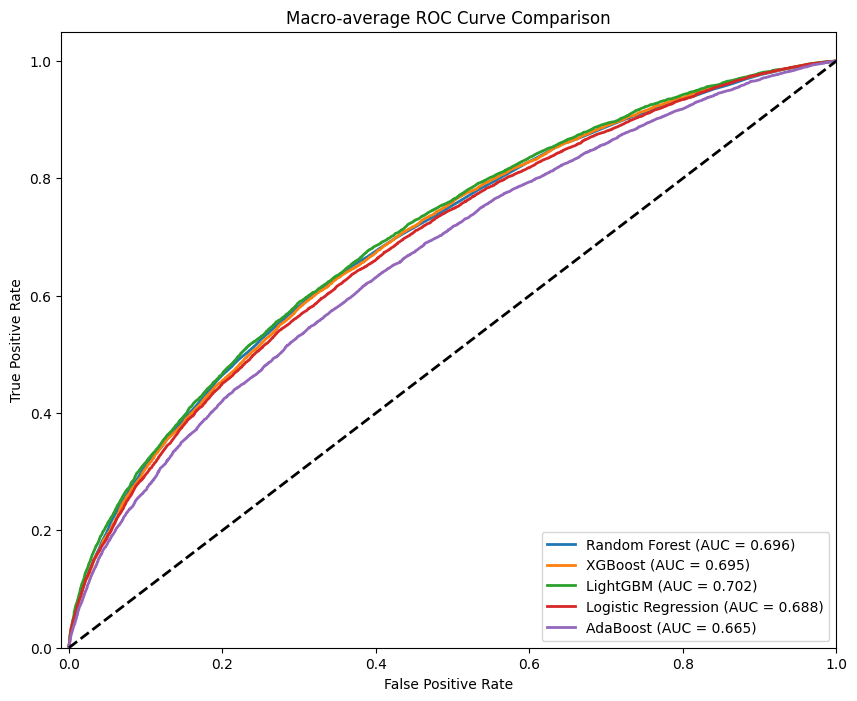

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# 初始化随机种子
np.random.seed(42)

# 数据预处理和分割的代码应在此处
# 假设已有 X_train_final, X_test_final, y_train, y_test

# ================== 模型训练和评估 ==================
# 随机森林
rf_final = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_final.fit(X_train_final, y_train)
rf_pred = rf_final.predict_proba(X_test_final)
rf_auc = roc_auc_score(y_test, rf_pred, multi_class='ovr', average='macro')
print(f"\nRandom Forest AUC: {rf_auc:.4f}")

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train)
xgb_pred = xgb_model.predict_proba(X_test_final)
xgb_auc = roc_auc_score(y_test, xgb_pred, multi_class='ovr', average='macro')
print(f"XGBoost AUC: {xgb_auc:.4f}")

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_final, y_train)
lgb_pred = lgb_model.predict_proba(X_test_final)
lgb_auc = roc_auc_score(y_test, lgb_pred, multi_class='ovr', average='macro')
print(f"LightGBM AUC: {lgb_auc:.4f}")

# Logistic Regression（需要数据标准化时可添加Pipeline）
lr_model = LogisticRegression(multi_class='multinomial', solver='saga',
                              max_iter=1000, random_state=42)
lr_model.fit(X_train_final, y_train)
lr_pred = lr_model.predict_proba(X_test_final)
lr_auc = roc_auc_score(y_test, lr_pred, multi_class='ovr', average='macro')
print(f"Logistic Regression AUC: {lr_auc:.4f}")

# AdaBoost
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train_final, y_train)
ada_pred = ada_model.predict_proba(X_test_final)
ada_auc = roc_auc_score(y_test, ada_pred, multi_class='ovr', average='macro')
print(f"AdaBoost AUC: {ada_auc:.4f}")

# ================== 输出分类报告 ==================
def print_report(model, name):
    pred = model.predict(X_test_final)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, pred))

print_report(rf_final, "Random Forest")
print_report(xgb_model, "XGBoost")
print_report(lgb_model, "LightGBM")
print_report(lr_model, "Logistic Regression")
print_report(ada_model, "AdaBoost")

# ================== 绘制ROC对比图 ==================
# 二值化标签处理
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# 定义ROC计算函数
def compute_macro_roc(y_true, y_pred_prob):
    fpr, tpr = {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

# 创建绘图
plt.figure(figsize=(10, 8))
models = [
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred),
    ('LightGBM', lgb_pred),
    ('Logistic Regression', lr_pred),
    ('AdaBoost', ada_pred)
]

# 绘制每个模型的ROC曲线
for name, pred in models:
    fpr, tpr, roc_auc = compute_macro_roc(y_test_bin, pred)
    plt.plot(fpr, tpr, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

# 绘制参考线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [16]:
!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_evaluate(max_depth, gamma, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'use_label_encoder': False
    }
    xgb_model = xgb.XGBClassifier(**params)
    auc = cross_val_score(xgb_model, X_train_final, y_train, cv=5, scoring='roc_auc_ovr').mean()
    return auc

def lgb_evaluate(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'random_state': 42
    }
    lgb_model = lgb.LGBMClassifier(**params)
    auc = cross_val_score(lgb_model, X_train_final, y_train, cv=5, scoring='roc_auc_ovr').mean()
    return auc

# XGBoost Bayesian Optimization
xgb_bo = BayesianOptimization(
    xgb_evaluate,
    {
        'max_depth': (3, 7),
        'gamma': (0, 0.5),
        'learning_rate': (0.05, 0.2),
        'n_estimators': (100, 400),
        'subsample': (0.6, 1),
        'colsample_bytree': (0.6, 1)
    },
    random_state=42
)
xgb_bo.maximize(init_points=10, n_iter=20)

# LightGBM Bayesian Optimization
lgb_bo = BayesianOptimization(
    lgb_evaluate,
    {
        'num_leaves': (20, 50),
        'learning_rate': (0.05, 0.2),
        'n_estimators': (100, 400),
        'subsample': (0.6, 1),
        'colsample_bytree': (0.6, 1)
    },
    random_state=42
)
lgb_bo.maximize(init_points=10, n_iter=20)

print("XGBoost best parameters:", xgb_bo.max)
print("LightGBM best parameters:", lgb_bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 1         | 0.6993    | 0.7498    | 0.4754    | 0.1598    | 5.395     | 146.8     | 0.6624    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:53:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 2         | 0.7007    | 0.6232    | 0.4331    | 0.1402    | 5.832     | 106.2     | 0.988     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 3         | 0.6994    | 0.933     | 0.1062    | 0.07727   | 3.734     | 191.3     | 0.8099    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 4         | 0.7013    | 0.7728    | 0.1456    | 0.1418    | 3.558     | 187.6     | 0.7465    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 5         | 0.7023    | 0.7824    | 0.3926    | 0.07995   | 5.057     | 277.7     | 0.6186    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:56:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:56:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:56:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 6         | 0.7017    | 0.843     | 0.08526   | 0.05976   | 6.796     | 389.7     | 0.9234    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 7         | 0.7       | 0.7218    | 0.04884   | 0.1526    | 4.761     | 136.6     | 0.7981    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 8         | 0.7025    | 0.6138    | 0.4547    | 0.08882   | 5.65      | 193.5     | 0.808     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 9         | 0.6879    | 0.8187    | 0.09243   | 0.1954    | 6.101     | 381.8     | 0.9579    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 10        | 0.6943    | 0.8392    | 0.4609    | 0.06327   | 3.784     | 113.6     | 0.7301    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:59:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 11        | 0.7014    | 0.8881    | 0.415     | 0.08008   | 6.556     | 196.7     | 0.6054    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 12        | 0.7002    | 0.923     | 0.292     | 0.1679    | 4.737     | 273.0     | 0.8648    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 13        | 0.6924    | 0.9349    | 0.3169    | 0.1198    | 6.992     | 394.5     | 0.7916    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 14        | 0.7019    | 0.7902    | 0.4077    | 0.1564    | 3.143     | 195.8     | 0.6412    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 15        | 0.699     | 0.9837    | 0.3292    | 0.05581   | 3.323     | 281.3     | 0.9754    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 16        | 0.6971    | 0.7014    | 0.034     | 0.1313    | 6.919     | 184.8     | 0.7572    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 17        | 0.7017    | 0.6069    | 0.2246    | 0.1376    | 3.267     | 199.7     | 0.7735    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 18        | 0.6987    | 0.7122    | 0.07746   | 0.1051    | 6.923     | 201.9     | 0.6494    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 19        | 0.7014    | 0.9532    | 0.08076   | 0.08549   | 6.875     | 101.6     | 0.6459    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 20        | 0.6991    | 0.8455    | 0.1334    | 0.1485    | 3.101     | 102.0     | 0.65      |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 21        | 0.7011    | 0.798     | 0.002846  | 0.07639   | 6.916     | 275.5     | 0.8494    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 22        | 0.7016    | 0.6051    | 0.4781    | 0.06551   | 6.897     | 130.4     | 0.8065    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 23        | 0.6971    | 0.8452    | 0.05756   | 0.09678   | 3.238     | 128.1     | 0.9748    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 24        | 0.6999    | 0.915     | 0.3443    | 0.1809    | 3.124     | 389.3     | 0.9202    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 25        | 0.6984    | 0.9164    | 0.2784    | 0.1592    | 6.986     | 133.4     | 0.9595    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 26        | 0.6887    | 0.7795    | 0.4549    | 0.1735    | 6.912     | 279.6     | 0.6768    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:08:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 27        | 0.7024    | 0.6888    | 0.3129    | 0.1388    | 3.051     | 347.6     | 0.7079    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 28        | 0.697     | 0.6418    | 0.371     | 0.1375    | 6.693     | 156.6     | 0.6793    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:09:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 29        | 0.6958    | 0.9658    | 0.06637   | 0.1249    | 6.1       | 251.0     | 0.6329    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

| 30        | 0.6981    | 0.8522    | 0.1018    | 0.09689   | 3.794     | 147.9     | 0.9888    |
|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 30563, number of used features: 24
[LightGBM] [Info] Start training from score -1.091732
[LightGBM] [Info] Start training from score -1.642975
[LightGBM] [Info] Start training from score -1.156050
[LightGBM] [Info] Start training from score -1.856396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5579
[LightGBM] [Info] Number of d

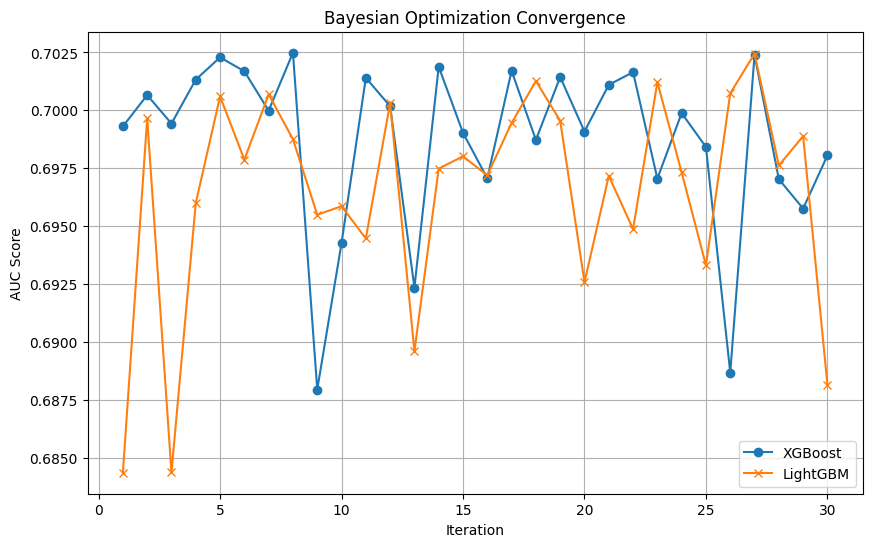

In [17]:
# prompt: 可视化收敛过程

import matplotlib.pyplot as plt

# Assuming xgb_bo and lgb_bo are your BayesianOptimization objects

# Extract optimization history for XGBoost
xgb_iterations = [i+1 for i in range(len(xgb_bo.res))]
xgb_target_values = [res['target'] for res in xgb_bo.res]


# Extract optimization history for LightGBM
lgb_iterations = [i+1 for i in range(len(lgb_bo.res))]
lgb_target_values = [res['target'] for res in lgb_bo.res]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(xgb_iterations, xgb_target_values, label='XGBoost', marker='o')
plt.plot(lgb_iterations, lgb_target_values, label='LightGBM', marker='x')

plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.title('Bayesian Optimization Convergence')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np

# 使用XGBoost最优参数训练模型
xgb_best_params = xgb_bo.max['params']
xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
xgb_best_params['n_estimators'] = int(xgb_best_params['n_estimators'])
xgb_best_params['objective'] = 'multi:softprob'
xgb_best_params['eval_metric'] = 'mlogloss'
xgb_best_params['random_state'] = 42
xgb_best_params['use_label_encoder'] = False

xgb_model = xgb.XGBClassifier(**xgb_best_params)
xgb_model.fit(X_train_final, y_train)

# 使用LightGBM最优参数训练模型
lgb_best_params = lgb_bo.max['params']
lgb_best_params['num_leaves'] = int(lgb_best_params['num_leaves'])
lgb_best_params['n_estimators'] = int(lgb_best_params['n_estimators'])
lgb_best_params['objective'] = 'multiclass'
lgb_best_params['metric'] = 'multi_logloss'
lgb_best_params['random_state'] = 42

lgb_model = lgb.LGBMClassifier(**lgb_best_params)
lgb_model.fit(X_train_final, y_train)

# 模型评估
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # 输出分类报告
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # 输出混淆矩阵
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 输出AUC
    print(f"AUC Score: {auc:.4f}")

    return auc

# 评估XGBoost模型
print("XGBoost Model Evaluation:")
xgb_auc = evaluate_model(xgb_model, X_test_final, y_test)

# 评估LightGBM模型
print("LightGBM Model Evaluation:")
lgb_auc = evaluate_model(lgb_model, X_test_final, y_test)

# 比较两个模型的AUC
print("\nModel Comparison:")
print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"LightGBM AUC: {lgb_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:45:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 38204, number of used features: 24
[LightGBM] [Info] Start training from score -1.091700
[LightGBM] [Info] Start training from score -1.643083
[LightGBM] [Info] Start training from score -1.156036
[LightGBM] [Info] Start training from score -1.856361
XGBoost Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.69      0.59      3176
           1       0.29      0.02      0.04      1897
           2       0.43      0.59      0.50      3029
           3       0.53      0.41      0.46      1450

    accuracy                           0.48      9552
   macro avg       0.44      0.43      0.40      9552
weighted avg       0.45      0.48      0.43      9552

Confusion M